In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from esmpy.datasets.base import generate_spim
from esmpy.estimators import SmoothNMF
from esmpy.measures import find_min_angle, find_min_MSE, ordered_mse, ordered_mae, ordered_r2


In [6]:
C = 15
L = 200
P = 100**2
seed = 0

n_poisson = 300 # Average poisson number per pixel (this number will be splitted on the L dimension)


In [7]:
def syntheticG(L=200, C=15, seed=None):

    np.random.seed(seed=seed)
    n_el = 45
    n_gauss = np.random.randint(2, 5,[C])
    l = np.arange(0, 1, 1/L)
    mu_gauss = np.random.rand(n_el)
    sigma_gauss = 1/n_el + np.abs(np.random.randn(n_el))/n_el/5

    G = np.zeros([L,C])

    def gauss(x, mu, sigma):
        # return np.exp(-(x-mu)**2/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
        return np.exp(-(x-mu)**2/(2*sigma**2))

    for i, c in enumerate(n_gauss):
        inds = np.random.choice(n_el, size=[c] , replace=False)
        for ind in inds:
            w = 0.1+0.9*np.random.rand()
            G[:,i] += w * gauss(l, mu_gauss[ind], sigma_gauss[ind])
    return G
 
def load_toy_images():
    im1 = plt.imread("../esmpy/datasets/toy-problem/phase1.png")
    im1 = (1-np.mean(im1, axis=2)) *0.5

    im2 = plt.imread("../esmpy/datasets/toy-problem/phase2.png")
    im2 = (1-np.mean(im2, axis=2)) *0.5

    im0 = 1 - im1 - im2 

    Hdot = np.array([im0, im1, im2])

    return Hdot


def create_toy_problem(L, C, n_poisson, seed=None):
    np.random.seed(seed=seed)
    G = syntheticG(L,C, seed=seed) 
    Hdot = load_toy_images()
    K = len(Hdot)
    Hdotflat = Hdot.reshape(K, -1)
    Wdot = np.abs(np.random.laplace(size=[C, K]))
    Wdot = Wdot / np.mean(Wdot)/L
    Ddot = G @ Wdot
    Ydot = Ddot @ Hdotflat

    Y = 1/n_poisson * np.random.poisson(n_poisson * Ydot)
    shape_2d = Hdot.shape[1:]
    return G, Wdot, Ddot, Hdot, Hdotflat, Ydot, Y, shape_2d, K

def plot_results(Ddot, D, Hdotflat, Hflat):
    fontsize = 30
    scale = 15
    aspect_ratio = 1.4
    marker_list = ["-o","-s","->","-<","-^","-v","-d"]
    mark_space = 20
    # cmap = plt.cm.hot_r    
    cmap = plt.cm.gray_r
    vmax = 1
    vmin = 0
    K = len(H)
    L = len(D)
    
    angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
    mse = ordered_mse(Hdotflat, Hflat, true_inds)
    mae = ordered_mae(Hdotflat, Hflat, true_inds)
    r2 = ordered_r2(Hdotflat, Hflat, true_inds)


    fig, axes = plt.subplots(K,3,figsize = (scale/K * 3 * aspect_ratio,scale))
    x = np.linspace(0,1, num = L)
    for i in range(K): 
        axes[2,i].plot(x,Ddot.T[i,:],'bo',label='truth',linewidth=4)
        axes[2,i].plot(x,D[:,true_inds[i]],'r-',label='reconstructed',markersize=3.5)
        axes[2,i].set_title("{:.2f} deg".format(angles[i]),fontsize = fontsize-2)
        axes[2,i].set_xlim(0,1)

        axes[1,i].imshow((Hflat[true_inds[i],:]).reshape(shape_2d),vmin = vmin, vmax = vmax , cmap=cmap)
        axes[1,i].set_title("R2: {:.2f}".format(r2[true_inds[i]]),fontsize = fontsize-2)
        # axes[i,1].set_ylim(0.0,1.0)
        axes[1,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)

        im = axes[0,i].imshow(Hdotflat[i].reshape(shape_2d),vmin = vmin, vmax = vmax, cmap=cmap)
        axes[0,i].set_title("Phase {}".format(i),fontsize = fontsize)
        axes[0,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
        axes[2,0].legend()

    rows = ["True maps","Reconstructed maps","Spectra"]

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=90, fontsize=fontsize)


    fig.subplots_adjust(right=0.84)
    # put colorbar at desire position
    cbar_ax = fig.add_axes([0.85, 0.5, 0.01, 0.3])
    fig.colorbar(im,cax=cbar_ax)

    # fig.tight_layout()

    plt.show()
    print("angles : ", angles)
    print("mse : ", mse)
    print("mae : ", mae)
    print("r2 : ", r2)

    
        

# Create a synthetic problem

Text(0.5, 1.0, 'Spectral response of each elements')

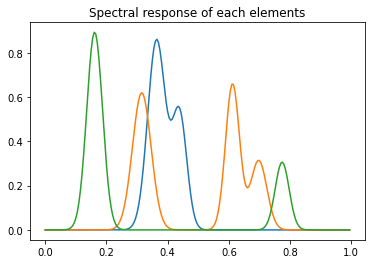

In [8]:
G = syntheticG(L,C, seed)
l = np.arange(0, 1, 1/L)
plt.plot(l, G[:,:3])
plt.title("Spectral response of each elements")


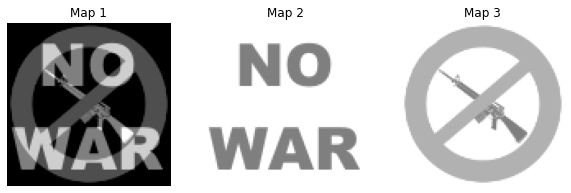

In [9]:

Hdot = load_toy_images()
vmin, vmax = 0,1
cmap = plt.cm.gray_r
plt.figure(figsize=(10, 3))
for i, hdot in enumerate(Hdot):
    plt.subplot(1,3,i+1)
    plt.imshow(hdot, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f"Map {i+1}")


In [10]:
G, Wdot, Ddot, Hdot, Hdotflat, Ydot, Y, shape_2d, K = create_toy_problem(L, C, n_poisson)

# Solve the problem

In [15]:

mu = 0
lambda_L = 0
force_simplex = False
Gused = None

params = {}
params["tol"]=1e-6
params["max_iter"] = 50
params["hspy_comp"] = False
params["verbose"] = 1
params["epsilon_reg"] = 1
params["linesearch"] = False
params["shape_2d"] = shape_2d
params["n_components"] = K

estimator = SmoothNMF(mu=mu, lambda_L=lambda_L, G = Gused, force_simplex=force_simplex, **params)
D = estimator.fit_transform(Y)
Hflat = estimator.H_
H = Hflat.reshape([Hflat.shape[0], *shape_2d])
W = estimator.W_

3


/Users/maxmartinezruts/.local/share/virtualenvs/esmpy-kBfF6zeU/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


It 10 / 50: loss 0.002,  23.500 it/s
It 20 / 50: loss 0.002,  24.869 it/s
It 30 / 50: loss 0.002,  25.218 it/s
It 40 / 50: loss 0.002,  25.516 it/s
exits because max_iteration was reached
Stopped after 50 iterations in 0.0 minutes and 2.0 seconds.


In [16]:
        
angles, true_inds = find_min_angle(Ddot.T, D.T, unique=True, get_ind=True)
mse = ordered_mse(Hdotflat, Hflat, true_inds)
print("angles : ", angles)
print("mse : ", mse)

AttributeError: 'tuple' object has no attribute 'T'

In [13]:
plot_results(Ddot, D, Hdotflat, Hflat)

AttributeError: 'tuple' object has no attribute 'T'

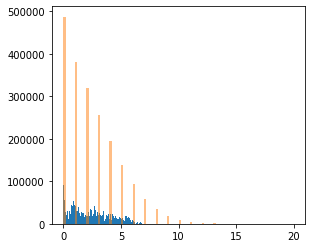

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hist(Ydot.flatten()*n_poisson, 100);
plt.subplot(1,2,1)
plt.hist(Y.flatten()*n_poisson, 100, alpha=0.5);